In [2]:
import astropy.io.fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial
import scipy.interpolate

In [3]:
gain = 5.5
R = 13

In [4]:
hdul = astropy.io.fits.open("ERS_NGTS10_2022_seg_038.fits")
#Assumptions for dark current subtraction
assert(hdul[0].header["NFRAMES"] == 1)
assert(hdul[0].header["GROUPGAP"] == 0)

In [5]:
hdul[1].data.shape

(44, 300, 416, 72)

In [6]:
for i in range(1, len(hdul)):
    print(hdul[i].header["EXTNAME"], hdul[i].data.shape)
data = hdul[1].data

SCI (44, 300, 416, 72)
PIXELDQ (416, 72)
REFOUT (44, 300, 416, 18)
ASDF (1,)


In [7]:
hdul[2].data.shape

(416, 72)

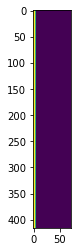

In [8]:
%matplotlib inline
plt.imshow(hdul[2].data != 0)


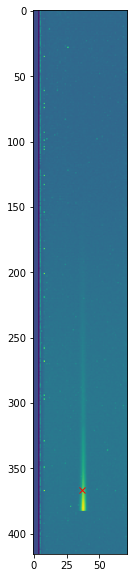

In [9]:
y = 367
#y = 382
x = 37

plt.figure(figsize=(10,10))
plt.imshow(data[0,-1])
plt.plot(x, y, 'x', color='r')

[  14.38024498 2106.22049562]
manual fit 14.380244978796206


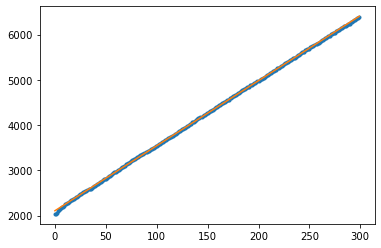

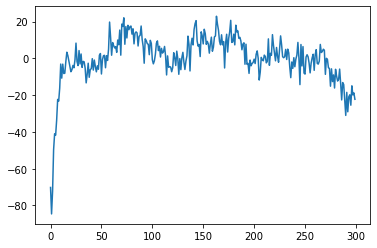

In [10]:
%matplotlib inline
xs = np.arange(data.shape[1])


#y = 367
#x = 1

coeffs = np.polyfit(xs, data[0,:,y,x], 1)
print(coeffs)
n = 300
print("manual fit", 12*np.sum(((xs+1) - (300+1)/2)*data[0,:,y,x]) / n / (n**2-1))

#coeffs[0] = 3.016
predicted = np.polyval(coeffs, xs)
residuals = data[0,:,y,x] - predicted

plt.plot(xs, data[0,:,y,x], '.')
plt.plot(xs, predicted)
#plt.xlim(0, 6)
#plt.ylim(2000,2200)
plt.figure()
plt.plot(xs, residuals)
plt.show()

37
(300,)


(1900.0, 2200.0)

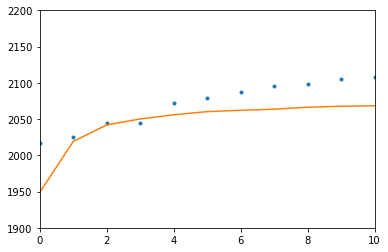

In [11]:
print(x)
master_ref = np.mean(data[0,:,:,0:4], axis=(1,2))
master_ref = np.mean(data[0,:,:,3], axis=1)
print(master_ref.shape)

plt.plot(xs, data[0,:,y,x-3], '.')
#plt.plot(xs, data[0,:,y,-1], '.')
plt.plot(xs, master_ref)
plt.xlim(0, 10)
plt.ylim(1900, 2200)

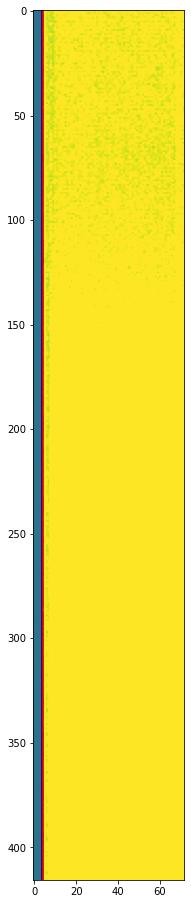

In [12]:
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(data[0,-1], vmin=1500, vmax=3000)
plt.axvline(4, color='r')
plt.show()

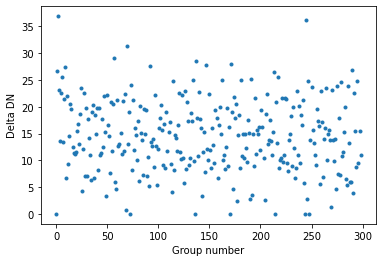

In [13]:
plt.plot(np.diff(np.array(data[0,:,y,x], dtype=float)), '.')
plt.xlabel("Group number")
plt.ylabel("Delta DN")
plt.savefig("group_values.png")

14.540594


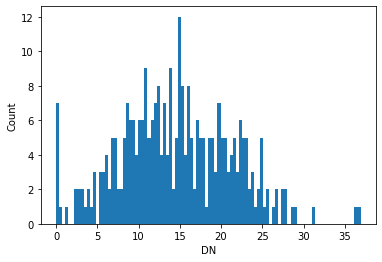

In [14]:
diffs = np.diff(data[0,:,y,x])
print(np.mean(diffs))
_ = plt.hist(diffs, bins=100)
plt.xlabel("DN")
plt.ylabel("Count")
plt.savefig("group_hist.png")

In [16]:
print(np.sum(diffs == 0), np.sum(diffs > 0))

7 292


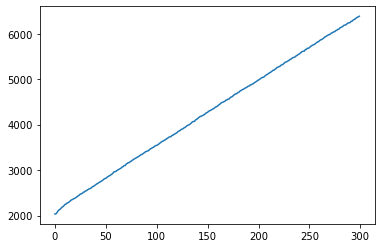

In [17]:
plt.plot(data[0,:,y,x])


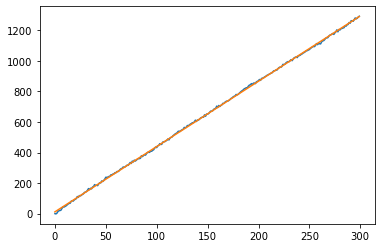

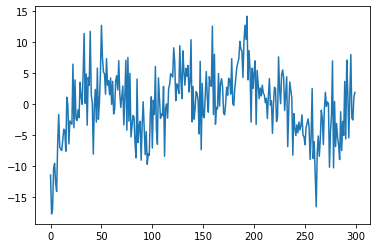

In [18]:
#Simulate the process
RN = 20
gain = 5.5
electrons_per_int = 24
N_groups = 300

xs = np.arange(N_groups)
electrons = np.zeros(N_groups)
measured = np.zeros(N_groups)

for i in range(1, N_groups):
    arrived = np.random.normal(electrons_per_int, np.sqrt(electrons_per_int))
    electrons[i] = electrons[i-1] + arrived
    measured[i] = np.floor(np.random.normal(electrons[i], RN) / gain)
    
#plt.plot(xs, measured)  
coeffs = np.polyfit(xs, measured, 1)
predicted = np.polyval(coeffs, xs)
residuals = measured - predicted    

plt.plot(xs, measured)
plt.plot(xs, predicted)
plt.figure()
plt.plot(xs, measured - predicted)

(array([ 1.,  3., 18., 15., 42., 74., 67., 40., 28., 11.]),
 array([-13., -10.,  -7.,  -4.,  -1.,   2.,   5.,   8.,  11.,  14.,  17.]),
 <a list of 10 Patch objects>)

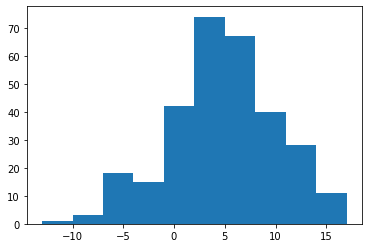

In [19]:
plt.hist(np.diff(measured))

In [20]:
print(np.std(np.diff(measured)))
print(np.std(diffs))

5.445128305739928
6.768636


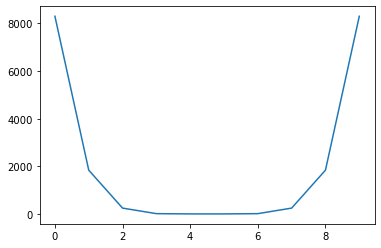

In [21]:
i = np.arange(10)
plt.plot(i, (i-4.5)**6)

[[0.     0.0276 0.    ]
 [0.0316 0.8816 0.0316]
 [0.     0.0276 0.    ]]
3


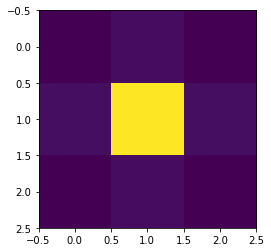

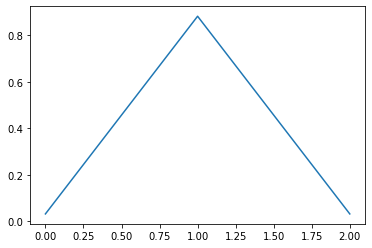

In [37]:
%matplotlib inline
ipc = astropy.io.fits.open("jwst_miri_ipc_0009.fits")
print(ipc[1].data)
plt.imshow(ipc[1].data)
plt.figure()
plt.plot(ipc[1].data[1])
print(len(ipc))

(4, 1024, 1032)


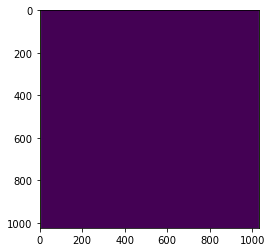

In [25]:
linearity = astropy.io.fits.open("jwst_miri_linearity_0014.fits")
print(linearity[1].data.shape)

(299,)
True


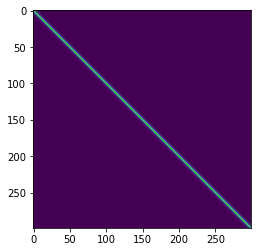

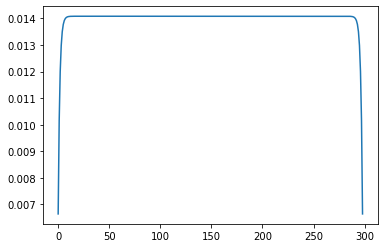

In [26]:
N_int = data.shape[1]
#print(N_int)
#K = np.zeros((N_int, N_int))

m = 71

K = np.diag((m + 2*R**2) * np.ones(N_int-1)) + np.diag(-R**2 * np.ones(N_int-2), -1) + np.diag(-R**2 * np.ones(N_int-2), 1)
#K += np.random.normal(0, 1e-2, K.shape)

inv_K = np.linalg.inv(K)
weights = np.sum(inv_K, axis=1)
print(weights.shape)
plt.imshow(inv_K)
plt.figure()
plt.plot(weights)


#Analytic weights
N = N_int - 1
l = np.arccosh(1 + m/R**2/2)
j = np.arange(1, N + 1)
analytic_weights = -R**-2 * np.exp(l) * (1 - np.exp(-j*l)) * (np.exp(j*l - l*N) - np.exp(l)) / (np.exp(l) - 1)**2 / (np.exp(l) + np.exp(-l*N))
print(np.allclose(weights, analytic_weights))

Symmetric True
Col sums correct? True
Grand sum correct? True


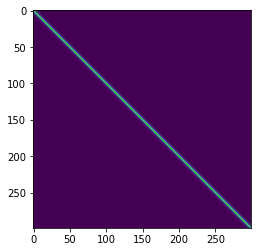

<Figure size 432x288 with 0 Axes>

In [27]:
#Try analytic inversion
l = np.arccosh((2 + m/R**2) / 2)
N_int = data.shape[1]
#print(N_int)

j, i = np.meshgrid(np.arange(1, N_int), np.arange(1, N_int))
#i, j = np.meshgrid(np.arange(N_int-1), np.arange(N_int-1))


#inverse = (np.cosh(l * (N + 1 - np.abs(j-i))) - np.cosh(l*(N+1-i-j))) / (2 * np.sinh(l) * np.sinh(l*(N + 1)))
inverse = R**-2 * (np.cosh(l * (N_int - np.abs(j-i))) - np.cosh(l*(N_int - i - j))) / (2 * np.sinh(l) * np.sinh(l*N_int))
#inverse = R**-2 * np.sinh(i*l) * np.sinh(l*(N_int - j)) / np.sinh(l) / np.sinh(l * N_int)

print("Symmetric", np.allclose(inverse, inverse.T))
plt.imshow(inverse)
#print(i, j.shape)

plt.figure()
#plt.plot(inverse[0])
#plt.plot(inv_K[0])

#print(l)
#print((2 + m/R**2)/2)

#print(inv_K[10,0:10])
#print(inverse[10,0:10])

#print(K.dot(inverse))
#print(K.dot(inv_K))
#print(K.shape, inverse.shape)

#print(np.allclose(inv_K, inverse))

a = np.exp(l)
j = np.arange(1, N_int)
N = N_int - 1
#col_sums = R**-2 * a**(1 - j) * (a**j - a**(2*j) + a**(1+j) + a**(1+2*j) + a**N_int + a**(j+N_int) + a**(1+j+N_int) - a**(1+N_int)) / ((a-1)**2 * (1+a) * (1+a**N_int))
col_sums = -R**-2 * np.exp(l) * (1 - np.exp(-j*l)) * (np.exp(j*l - l*N) - np.exp(l)) / (np.exp(l) - 1)**2 / (np.exp(l) + np.exp(-l*N)) #np.exp(l-l*j) * (np.exp(j*l) - 1) * (np.exp(j*l) - np.exp(l + l*N)) / (-1 + np.exp(l))**2 / (1 + np.exp(l + l*N))


print("Col sums correct?", np.allclose(col_sums, np.sum(inverse, axis=0)))
grand_sum = R**-2 * np.exp(l) * (-N*np.exp(-l*N) + np.exp(2*l)*N + np.exp(l-l*N)*(2+N) - np.exp(l)*(2+N)) / (np.exp(l) - 1)**3 / (np.exp(-l*N) + np.exp(l))
print("Grand sum correct?", np.allclose(grand_sum, np.sum(col_sums)))
#print(grand_sum)
#print(np.sum(col_sums), np.sum(inverse))

0 0.01
10 0.025353644939701114
20 0.06428073117284322
30 0.16297508346206444
40 0.41320124001153385
50 1.0476157527896652
60 2.656087782946687
70 6.7341506577508286
80 17.07352647470692
90 43.287612810830616
0.13097405433654785


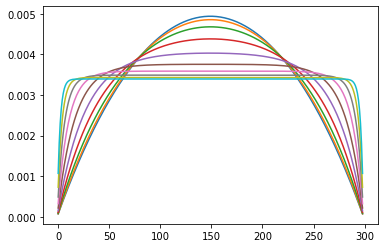

In [29]:
#construct library of weights
import time
R = 13
N_int = 300
all_ratios = np.logspace(-2, 2, 100)
all_weights = []
all_weight_norms = []

start = time.time()
for i, signal_over_read_var in enumerate(all_ratios):
    m = signal_over_read_var * R**2 / (N_int - 1)
    K = np.diag((m/R**2 + 2) * np.ones(N_int-1)) + np.diag(-np.ones(N_int-2), -1) + np.diag(-np.ones(N_int-2), 1) 
    inv_K = np.linalg.inv(K)
    weights = np.sum(inv_K, axis=1)
    #print(weights)
    all_weight_norms.append(np.sum(weights))
    weights /= np.sum(weights)
    all_weights.append(weights)
    if i % 10 == 0:
        print(i, signal_over_read_var)
        plt.plot(weights)
    
all_weights = np.array(all_weights)    
all_weight_norms = np.array(all_weight_norms)
end = time.time()
print(end - start)

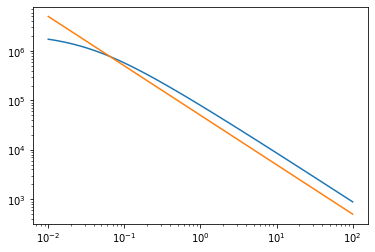

In [30]:
plt.loglog(all_ratios, all_weight_norms)
plt.loglog(all_ratios, 1/all_ratios**1 * 5e4)

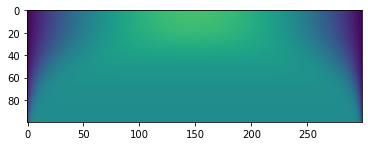

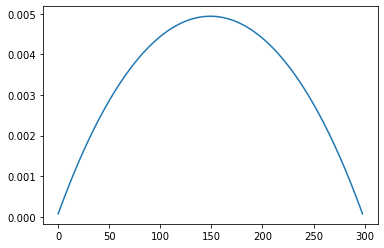

In [31]:
plt.imshow(all_weights, vmin=0, vmax=0.007)
#print(all_weights)
plt.figure()
#plt.plot(np.sum(all_weights, axis=0))
plt.plot(all_weights[0])

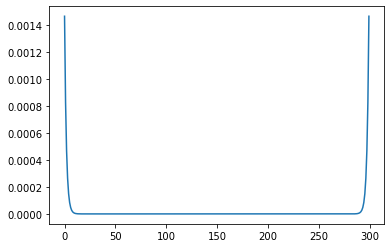

In [32]:
diff_weights = np.abs(np.append(weights, 0) - np.append(0, weights))
plt.plot(diff_weights)

In [34]:
flat = astropy.io.fits.open("jwst_miri_flat_0745.fits")
print(flat)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f746c9fa438>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f746ca0d1d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f746ca0d9b0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f746ca10240>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f746ca10c50>]


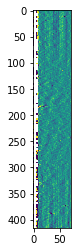

In [35]:
%matplotlib inline
plt.imshow(flat[1].data, vmin=0.99, vmax=1.01)
